In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import hmean
from sklearn.manifold import TSNE

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


import tf_lab.autopredictors.scripts.virt_scan_data as vscan

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, points_extension, \
                                                 shape_net_core_synth_id_to_category


from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch
        
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs, accuracy_of_completion, \
                                           coverage_of_completion, save_reconstructions, \
                                           save_pc_prediction_stats, save_stats_of_multi_class_experiments, \
                                           paper_pc_completion_experiment_id_best_epoch
                                                  
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud


from tf_lab.nips.model_net import pc_loader, classes_to_integers


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
GPU = [1]
loss = 'chamfer'
n_pc_samples = 2048

In [4]:
experiment_name = '1_three_fc_dec_spn_2048pts_chamfer'
# experiment_name = '2_three_fc_dec_2048pts'

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

# train_dir = osp.join(top_data_dir, 'OUT/models/vanilla_ae/full_SN')
# train_dir = osp.join(top_data_dir, 'OUT/models/nips/denoising_ae/')
train_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae/')

train_dir = osp.join(train_dir, experiment_name)

conf = Conf.load(osp.join(train_dir, 'configuration'))
print conf
conf.n_output = conf.n_input

                    batch_size: 50
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'non_linearity': <function relu at 0x7efcd7499e60>, 'layer_sizes': [512, 1024, 6144]}
                       encoder: encoder_with_convs_and_symmetry
                  encoder_args: {}
               experiment_name: 1_three_fc_dec_spn_2048pts_chamfer
                 gauss_augment: None
                  is_denoising: False
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: chamfer
             loss_display_step: 1
                       n_input: [2048, 3]
                      n_output: [2048, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 10
                     train_dir: /orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/vanilla_ae/1_three_fc_dec_spn_2048pts_cham

In [5]:
reset_tf_graph()
set_visible_GPUs(GPU)
ae = PointNetAutoEncoder(experiment_name, conf)
saved_epochs = read_saved_epochs(conf.train_dir)
last_epoch = saved_epochs[-1]
ae.restore_model(conf.train_dir, last_epoch, verbose=True)

Model restored in epoch 1000.


In [6]:
model_net_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Point_Clouds/Model_Net_40/from_manifold/'

search_pattern = '(.*)train(.*)\.ply$'
train_pc_files = [f for f in files_in_subdirs(model_net_dir, search_pattern)]

search_pattern = '(.*)test(.*)\.ply$'
test_pc_files = [f for f in files_in_subdirs(model_net_dir, search_pattern)]

In [7]:
pc, model_names, labels = pio.load_crude_point_clouds(train_pc_files, loader=pc_loader, n_threads=10, verbose=True)
train_data = PointCloudDataSet(pc, labels=labels)
pc, model_names, labels = pio.load_crude_point_clouds(test_pc_files, loader=pc_loader, n_threads=10, verbose=True)
test_data = PointCloudDataSet(pc, labels=labels)

9841 pclouds were loaded. They belong in 40 shape-classes.
2467 pclouds were loaded. They belong in 40 shape-classes.


In [10]:
train_feed, train_latent, train_classes = latent_embedding_of_entire_dataset(train_data, ae, conf)

In [12]:
cids = classes_to_integers(40, train_classes)[1]
print cids
# u_l = np.unique(labels)
# d = {l:i for i,l in enumerate(u_l)}
# cids = [d[i] for i in train_classes]

[30, 32, 8, 15, 26, 23, 31, 29, 4, 15, 0, 12, 21, 37, 6, 0, 37, 8, 2, 5, 8, 22, 18, 2, 8, 30, 12, 32, 5, 27, 36, 31, 21, 4, 12, 30, 35, 2, 35, 2, 17, 33, 30, 21, 4, 26, 33, 16, 0, 4, 37, 8, 9, 32, 5, 35, 30, 27, 37, 2, 8, 0, 34, 37, 35, 31, 2, 30, 35, 0, 12, 8, 13, 8, 26, 34, 8, 15, 0, 22, 4, 8, 11, 9, 21, 5, 30, 10, 7, 5, 25, 8, 33, 14, 25, 8, 33, 8, 4, 0, 8, 0, 0, 37, 0, 25, 0, 36, 36, 17, 34, 35, 33, 33, 35, 6, 8, 15, 22, 22, 35, 26, 37, 5, 14, 4, 16, 15, 37, 22, 18, 22, 26, 26, 12, 19, 8, 12, 37, 2, 2, 23, 19, 21, 4, 0, 17, 0, 4, 30, 35, 14, 34, 22, 17, 5, 30, 37, 2, 4, 22, 4, 1, 8, 37, 13, 0, 35, 13, 22, 12, 0, 37, 0, 0, 4, 26, 16, 16, 8, 20, 15, 2, 28, 25, 22, 29, 0, 36, 8, 2, 19, 0, 33, 26, 34, 5, 23, 33, 4, 14, 35, 7, 4, 14, 15, 12, 8, 22, 33, 36, 4, 2, 0, 37, 30, 8, 21, 21, 7, 16, 8, 8, 37, 4, 24, 2, 25, 37, 4, 5, 5, 21, 0, 8, 9, 18, 23, 28, 4, 36, 5, 23, 35, 2, 5, 15, 12, 0, 2, 30, 14, 37, 8, 8, 16, 17, 21, 8, 4, 37, 6, 33, 2, 27, 33, 4, 38, 8, 33, 17, 11, 4, 5, 24, 8, 39, 26

In [13]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(train_latent, cids)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [14]:
test_feed, test_latent, test_classes = latent_embedding_of_entire_dataset(test_data, ae, conf)

# u_l = np.unique(labels)
# d = {l:i for i,l in enumerate(u_l)}
# cids = [d[i] for i in test_classes]

cids = classes_to_integers(40, test_classes)[1]
lsvc.score(test_latent, cids)

0.85204702067288207

In [13]:
np.sum(lsvc.predict(test_latent) == cids) / float(len(cids))

0.94493392070484583

In [103]:
model = TSNE(n_components=2, init='pca', verbose=True, random_state=0)
tsne_emb = model.fit_transform(latent)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3991
[t-SNE] Computed conditional probabilities for sample 2000 / 3991
[t-SNE] Computed conditional probabilities for sample 3000 / 3991
[t-SNE] Computed conditional probabilities for sample 3991 / 3991
[t-SNE] Mean sigma: 0.220372
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.328276
[t-SNE] Error after 325 iterations: 1.328276


In [17]:
u_ids = np.unique(train_classes)
print u_ids
d = {cid:i for i, cid in zip(range(len(u_ids)), u_ids)}


['bathtub' 'bed' 'chair' 'desk' 'dresser' 'monitor' 'night_stand' 'sofa'
 'table' 'toilet']


In [61]:
shape_net_category_to_synth_id()

{'airplane': '02691156',
 'bag': '02773838',
 'basket': '02801938',
 'bathtub': '02808440',
 'bed': '02818832',
 'bench': '02828884',
 'bicycle': '02834778',
 'birdhouse': '02843684',
 'bookshelf': '02871439',
 'bottle': '02876657',
 'bowl': '02880940',
 'bus': '02924116',
 'cabinet': '02933112',
 'camera': '02942699',
 'can': '02747177',
 'cap': '02954340',
 'car': '02958343',
 'chair': '03001627',
 'clock': '03046257',
 'dishwasher': '03207941',
 'earphone': '03261776',
 'faucet': '03325088',
 'file': '03337140',
 'guitar': '03467517',
 'helmet': '03513137',
 'jar': '03593526',
 'keyboard': '03085013',
 'knife': '03624134',
 'lamp': '03636649',
 'laptop': '03642806',
 'mailbox': '03710193',
 'microphone': '03759954',
 'microwave': '03761084',
 'monitor': '03211117',
 'motorcycle': '03790512',
 'mug': '03797390',
 'piano': '03928116',
 'pillow': '03938244',
 'pistol': '03948459',
 'pot': '03991062',
 'printer': '04004475',
 'remote_control': '04074963',
 'rifle': '04090263',
 'rocket'

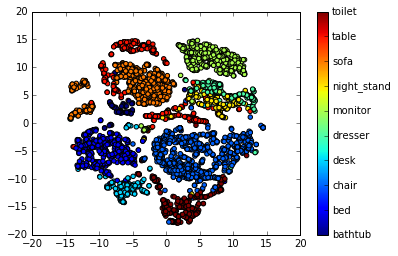

In [104]:
c = [d[cid] for cid in ids]
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=c)
color_bar_labels = u_ids
cbar = plt.colorbar(ticks=range(len(u_ids)))
cbar.set_ticklabels(color_bar_labels)


# cbar = plt.colorbar(ticks=range(0,9))
# cbar.set_ticklabels(color_bar_labels)
# plt.grid()
# plt.suptitle('TSNE of Test Data - %s Loss.' % (loss, ))

In [121]:
pc = pc_data.next_batch(1)
pc

(array([[[-0.11548442, -0.27953228, -0.09153726],
         [-0.12083969,  0.28681359, -0.09153724],
         [ 0.02250452, -0.34106886, -0.09153722],
         ..., 
         [ 0.0573894 , -0.44271106,  0.09153726],
         [ 0.01733515, -0.43751174,  0.09153726],
         [ 0.02702635,  0.45654172,  0.09153726]]], dtype=float32),
 array(['table'], dtype=object),
 None)

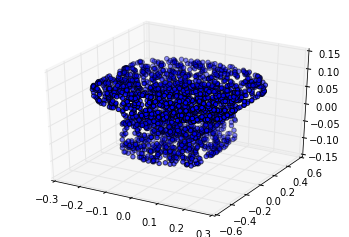

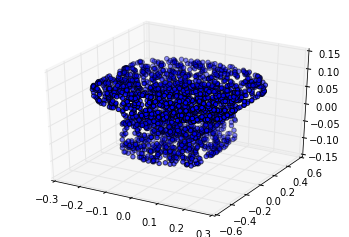

In [125]:
Point_Cloud(points=np.squeeze(pc[0])).plot()